In [1]:
import os
import re

import pandas as pd
import numpy as np

import nlp
import nltk
from nltk import tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from itertools import compress
import collections
from collections import Counter

import spacy 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import warnings
from pandas.core.common import SettingWithCopyWarning

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Preprocessing

In [3]:
# import data as dataframe
data = pd.read_excel("cleaned_all.xlsx")

In [4]:
data['Sound Bite Text'].astype(str)
data['text']=data['Sound Bite Text'].str.lower()
data.dropna(subset=['Sound Bite Text'], inplace=True)
data['text'] = data['text'].astype('string')
data['text_split']=data['text'].str.split()
data = data.dropna(subset=['Sound Bite Text'])
data = data[data['Sound Bite Text']!='nan']
data.dropna(subset=['text_split'], inplace=True)

### Filter Reviews that is related to Apple

In [5]:
getApple = ['iphone','x', '8']

def filter_apple(splitlist):
    nltk=[]
    for i in splitlist:
        if i in getApple:
            nltk.append(i)
    return list(set(nltk))
data['apple_tag'] = data['text_split'].apply(filter_apple)

### Filter Reviews that is related to Samsung

In [6]:
getSamsung = ['galaxy','s8', 'samsung']

def filter_samsung(splitlist):
    nltk=[]
    for i in splitlist:
        if i in getSamsung:
            nltk.append(i)
    return list(set(nltk))
data['samsung_tag'] = data['text_split'].apply(filter_samsung)

In [7]:
data['samsung'] = data['samsung_tag'].apply(lambda s: 1 if len(s) != 0 else 0)
data['apple'] = data['apple_tag'].apply(lambda s: 1 if len(s) != 0 else 0)

In [8]:
data['both'] = data['samsung']+data['apple']
data = data.drop('samsung_tag',1)
data = data.drop('apple_tag',1)

/var/folders/vg/pr1vdfbs7xj4xh3qmndt97m40000gn/T/ipykernel_24971/1877862849.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('samsung_tag',1)
/var/folders/vg/pr1vdfbs7xj4xh3qmndt97m40000gn/T/ipykernel_24971/1877862849.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('apple_tag',1)


In [9]:
################################################

# Remove stopwords and irrelavant words

In [10]:
# function to remove URL
def delete_URL(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    
    data=re.sub(r'/.*', "", data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    
    data = re.sub(r'[A-Za-z]*.com$', "", data)

        
    return data

In [11]:
# function to remove stop words
tknzr = TweetTokenizer()
nlp = spacy.load("en_core_web_sm")

def remove_stop_words(string):
    cleaned=[word for word in tknzr.tokenize(string.lower()) if word not in nlp.Defaults.stop_words and len(word)>2]
    cleaned_str = ' '.join(cleaned)   
    return cleaned_str

In [12]:
# clear url & stop words for samsung
data['Sound Bite Text'] = data['Sound Bite Text'].apply(delete_URL)
data['Sound Bite Text'] = data['Sound Bite Text'].apply(remove_stop_words)

In [13]:
# sentiment for all data using textblob
data['s score_all'] = data['Sound Bite Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data["sentiment_all"] = np.select([data["s score_all"] < 0, data["s score_all"] == 0, data["s score_all"] > 0],['neg', 'neu', 'pos'])

In [14]:
data_new = data.drop(data[data['both']==2].index)
data_new.groupby("samsung")['s score_all'].median()

samsung
0    0.096257
1    0.100000
Name: s score_all, dtype: float64

In [15]:
data_new.groupby("apple")['s score_all'].median()

apple
0    0.100000
1    0.099074
Name: s score_all, dtype: float64

# Sentiment Analysis of Samsung

In [16]:
samsung = data[(data['samsung']==1) & (data['both']!=2)]
samsung.head()

,Post ID,Sound Bite Text,Source Type,Published Date (GMT-04:00) New York,Author Location - Country 1,No. of Followers/Daily Unique Visitors,Richness,text,text_split,samsung,apple,both,s score_all,sentiment_all
0,854083902402580480,samsung galaxy plus undergo battery drain test...,Twitter,"Apr 17, 2017 5:27:25 PM",France,50,2,samsung galaxy s8 and s8 plus undergo a batter...,"[samsung, galaxy, s8, and, s8, plus, undergo, ...",1,0,1,0.0,neu
2,875563699074850816,#unieuro #sconta #galaxy del #fino #domenica,Twitter,"Jun 16, 2017 12:00:27 AM",NaN,190,2,#unieuro #sconta #galaxy s8 ed s8+ del 19 e 22...,"[#unieuro, #sconta, #galaxy, s8, ed, s8+, del,...",1,0,1,0.0,neu
3,860350966855598082,enjoy free cup aromatic coffee samsung galaxy ...,Twitter,"May 5, 2017 12:30:29 AM",NaN,444,3,enjoy a free cup of aromatic coffee from us at...,"[enjoy, a, free, cup, of, aromatic, coffee, fr...",1,0,1,0.4,pos
4,837438402651901953,according reports samsung begun mass productio...,Twitter,"Mar 2, 2017 6:04:08 PM",United States,23,2,"according to reports, samsung has begun mass p...","[according, to, reports,, samsung, has, begun,...",1,0,1,0.0,neu
8,880244325912858624,review samsung galaxy bit.ly,Twitter,"Jun 28, 2017 9:59:36 PM",NaN,8,1,review & keep a samsung galaxy s8! bit.ly/2jvz...,"[review, &, keep, a, samsung, galaxy, s8!, bit...",1,0,1,0.0,neu


In [17]:
# texblob- samsung
samsung['sentiment score'] = samsung['Sound Bite Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
samsung["sentiment"] = np.select([samsung["sentiment score"] < 0, samsung["sentiment score"] == 0, samsung["sentiment score"] > 0],['neg', 'neu', 'pos'])

<AxesSubplot:xlabel='sentiment'>

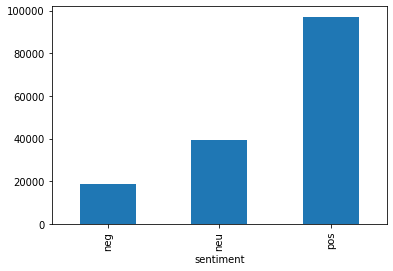

In [18]:
# based on textblob-samsung
samsung.groupby('sentiment')['Post ID'].count().plot(kind ='bar')

In [19]:
samsung.groupby('sentiment')['Post ID'].count()

sentiment
neg    18905
neu    39454
pos    97053
Name: Post ID, dtype: int64

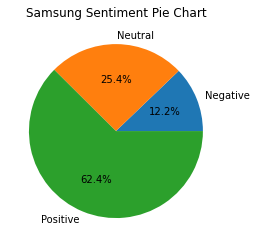

In [21]:
mylabels = ["Negative", "Neutral", "Positive"]
plt.pie(samsung.groupby('sentiment')['Post ID'].count(), labels = mylabels, autopct='%1.1f%%')
plt.title("Samsung Sentiment Pie Chart")
plt.show()

In [23]:
# vader on samsung
import operator
sia = SentimentIntensityAnalyzer()
samsung["sentiment_score_2"] = samsung["Sound Bite Text"].apply(lambda x: sia.polarity_scores(x)["compound"])
samsung["sentiment_2"] = np.select([samsung["sentiment_score_2"] < 0, samsung["sentiment_score_2"] == 0, samsung["sentiment_score_2"] > 0],
                           ['neg', 'neu', 'pos'])


<AxesSubplot:xlabel='sentiment_2'>

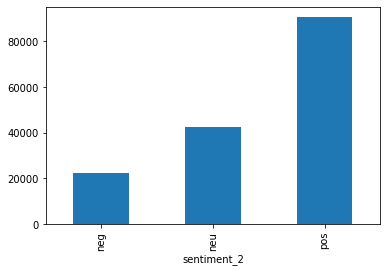

In [24]:
# based on vader-samsung
samsung.groupby('sentiment_2')['Post ID'].count().plot(kind ='bar')

# Sentiment Analysis of Apple

In [25]:
apple = data[(data['apple']==1) & (data['both']!=2)]

In [26]:
# textBlob on Apple
apple['sentiment score'] = apple['Sound Bite Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
apple["sentiment"] = np.select([apple["sentiment score"] < 0, apple["sentiment score"] == 0, apple["sentiment score"] > 0],['neg', 'neu', 'pos'])

In [27]:
apple.groupby('sentiment')['Post ID'].count()

sentiment
neg    21183
neu    37677
pos    99341
Name: Post ID, dtype: int64

In [28]:
# vader on Apple
sia = SentimentIntensityAnalyzer()
apple["sentiment_score_2"] = apple["Sound Bite Text"].apply(lambda x: sia.polarity_scores(x)["compound"])
apple["sentiment_2"] = np.select([apple["sentiment_score_2"] < 0, apple["sentiment_score_2"] == 0, apple["sentiment_score_2"] > 0],
                           ['neg', 'neu', 'pos'])

<AxesSubplot:xlabel='sentiment_2'>

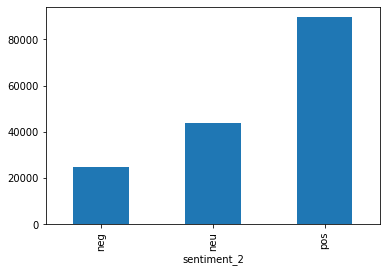

In [29]:
apple.groupby('sentiment_2')['Post ID'].count().plot(kind ='bar')

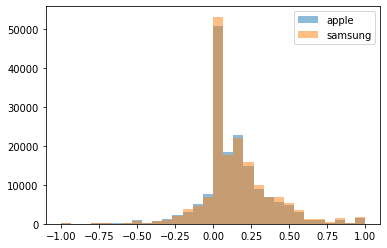

In [30]:
plt.hist(apple['sentiment score'], alpha = 0.5, bins= 30)
plt.hist(samsung['sentiment score'], alpha = 0.5, bins = 30)
plt.legend(["apple", "samsung"])
plt.show()

# Analysis of before-launch & after-launch

In [31]:
def samsung_launch(date):
    if pd.to_datetime(date) < pd.to_datetime('03-29-2017'):
        status = 'before'
    else:
         status = 'after'
    return status

In [32]:
samsung['before and after'] = samsung['Published Date (GMT-04:00) New York'].apply(samsung_launch)

In [33]:
def apple_launch(date):
    if pd.to_datetime(date) < pd.to_datetime('09-22-2017'):
        status = 'before'
    else:
         status = 'after'
    return status

In [34]:
apple['before and after'] = apple['Published Date (GMT-04:00) New York'].apply(apple_launch)

In [35]:
apple.groupby("before and after")['sentiment score'].mean()

before and after
after     0.139245
before    0.114966
Name: sentiment score, dtype: float64

In [36]:
samsung.groupby("before and after")['sentiment score'].mean()

before and after
after     0.145929
before    0.100604
Name: sentiment score, dtype: float64

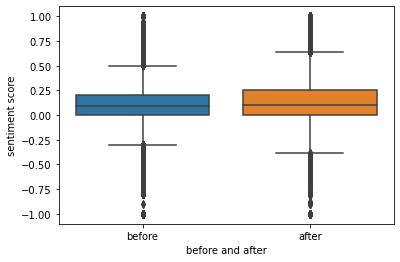

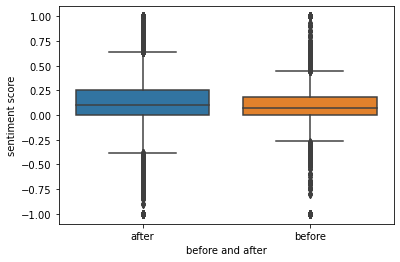

In [37]:
sns.boxplot(x='before and after', y='sentiment score', data=apple)
plt.show()
sns.boxplot(x='before and after', y='sentiment score', data=samsung)
plt.show()

In [38]:
import datetime
import dateutil
apple['publish date']= apple['Published Date (GMT-04:00) New York'].apply(dateutil.parser.parse, dayfirst=True)
apple['publish date'] = [d.date() for d in apple["publish date"]]

## time serie sentiment score for apple 

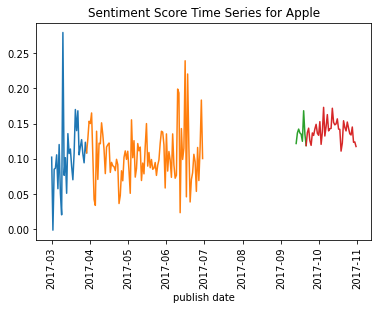

In [39]:
# pre samsung launch
apple[apple['publish date']<datetime.date(2017,3,30)].groupby('publish date')['sentiment score'].mean().plot()
# post samsung launch
apple[(apple['publish date']>datetime.date(2017,3,28)) & (apple['publish date']<datetime.date(2017,7,1))].groupby('publish date')['sentiment score'].mean().plot()
# pre apple lanuch
apple[(apple['publish date']>datetime.date(2017,9,12)) & (apple['publish date']<datetime.date(2017,9,22))].groupby('publish date')['sentiment score'].mean().plot()
# post apple launch
apple[(apple['publish date']>datetime.date(2017,9,20))].groupby('publish date')['sentiment score'].mean().plot()
plt.xticks(rotation='vertical')
plt.title("Sentiment Score Time Series for Apple")
plt.show()

## time serie number of post for apple

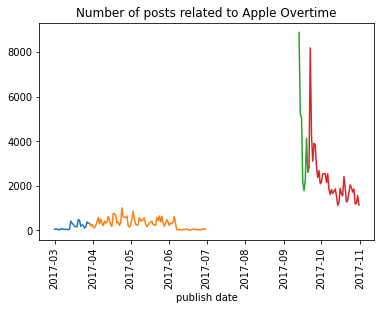

In [40]:
# pre samsung launch
apple[apple['publish date']<datetime.date(2017,3,30)].groupby('publish date')['Post ID'].count().plot()
# post samsung launch
apple[(apple['publish date']>datetime.date(2017,3,28)) & (apple['publish date']<datetime.date(2017,7,1))].groupby('publish date')['Post ID'].count().plot()
# pre apple lanuch
apple[(apple['publish date']>datetime.date(2017,9,12)) & (apple['publish date']<datetime.date(2017,9,22))].groupby('publish date')['Post ID'].count().plot()
# post apple launch
apple[(apple['publish date']>datetime.date(2017,9,20))].groupby('publish date')['Post ID'].count().plot()
plt.title("Number of posts related to Apple Overtime")
plt.xticks(rotation='vertical')
plt.show()


## time serie plot number of post related to samsung

In [41]:
samsung['publish date']= samsung['Published Date (GMT-04:00) New York'].apply(dateutil.parser.parse, dayfirst=True)
samsung['publish date'] = [d.date() for d in samsung["publish date"]]

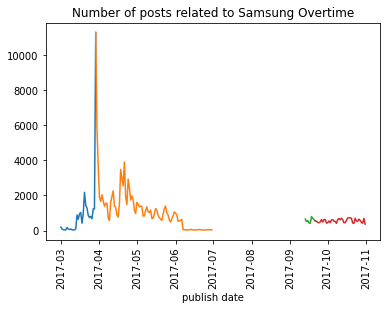

In [42]:
# time serie plot number of post related to samsung
# pre samsung launch
samsung[samsung['publish date']<datetime.date(2017,3,30)].groupby('publish date')['Post ID'].count().plot()
# post samsung launch
samsung[(samsung['publish date']>datetime.date(2017,3,28)) & (samsung['publish date']<datetime.date(2017,7,1))].groupby('publish date')['Post ID'].count().plot()
# pre apple lanuch
samsung[(samsung['publish date']>datetime.date(2017,9,12)) & (samsung['publish date']<datetime.date(2017,9,22))].groupby('publish date')['Post ID'].count().plot()
# post apple launch
samsung[(samsung['publish date']>datetime.date(2017,9,20))].groupby('publish date')['Post ID'].count().plot()
plt.title("Number of posts related to Samsung Overtime")

plt.xticks(rotation='vertical')
plt.show()

## time series plot for sentiment score of samsung

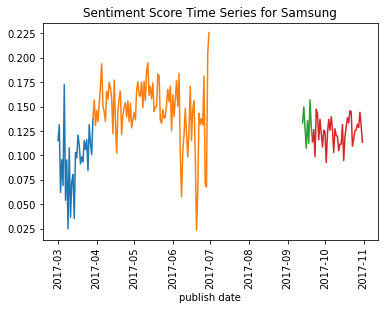

In [43]:
# time series plot for sentiment score of samsung
# pre samsung launch
samsung[samsung['publish date']<datetime.date(2017,3,30)].groupby('publish date')['sentiment score'].mean().plot()
# post samsung launch
samsung[(samsung['publish date']>datetime.date(2017,3,28)) & (samsung['publish date']<datetime.date(2017,7,1))].groupby('publish date')['sentiment score'].mean().plot()
# pre apple lanuch
samsung[(samsung['publish date']>datetime.date(2017,9,12)) & (samsung['publish date']<datetime.date(2017,9,22))].groupby('publish date')['sentiment score'].mean().plot()
# post apple launch
samsung[(samsung['publish date']>datetime.date(2017,9,20))].groupby('publish date')['sentiment score'].mean().plot()
plt.xticks(rotation='vertical')
plt.title("Sentiment Score Time Series for Samsung")
plt.show()